<a href="https://colab.research.google.com/github/a6iyyu/MachineLearning_3F_23/blob/main/JS10/src/tugas-lab-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚌 Tugas Lab 1**

1. Buatlah model klasifikasi dengan menggunakan kNN untuk mengklasifikasikan jenis suara `male` dan `female` pada dataset `voice.csv`.

2. Lakukan percobaan untuk mengetahui fitur-fitur yang paling optimal untuk digunakan. Fitur apa saja yang Anda gunakan untuk mendapatkan hasil terbaik?

3. Berdasarkan fitur yang telah Anda pilih pada soal nomor 2, berapa nilai `k` yang terbaik? Lampirkan grafika analisis dan alasan Anda.

In [1]:
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import io
import numpy as np
import os
import pandas as pd

In [2]:
filename = 'voice.csv'
file_ready = False

if os.path.exists(filename):
    print(f"File '{filename}' sudah ada. Langsung memuat...")
    file_ready = True
else:
    print(f"File '{filename}' tidak ditemukan. Silakan upload file:")
    uploaded = files.upload()

    if filename in uploaded:
        print(f"File '{filename}' berhasil diupload.")
        file_ready = True
    else:
        print(f"Error: File '{filename}' tidak ditemukan di antara file yang diupload.")

if file_ready:
    try:
        try:
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
        except NameError:
            # Kasus 2: File SUDAH ADA (os.path.exists == True)
            df = pd.read_csv(filename)

        print("\n--- Informasi Data Awal ---")
        print(df.info())
        print("\nContoh Data:")
        print(df.head())

    except pd.errors.EmptyDataError:
        print(f"Error: File '{filename}' ditemukan, tapi isinya kosong.")

    except Exception as e:
        print(f"Terjadi error saat membaca file: {e}")

File 'voice.csv' tidak ditemukan. Silakan upload file:


Saving voice.csv to voice.csv
File 'voice.csv' berhasil diupload.

--- Informasi Data Awal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   316

In [3]:
# Konversi label 'male'/'female' menjadi numerik (1/0)
# Ini penting untuk analisis korelasi
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
# le.classes_ akan menunjukkan ['female', 'male'], artinya female=0, male=1

# Pisahkan fitur (X) dan target (y)
# Kita gunakan label_encoded sebagai target
X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

In [4]:
# --- TUGAS 1: Model Klasifikasi kNN (Baseline) ---
print("\n--- TUGAS 1: Model Baseline (Semua Fitur) ---")

# Bagi data menjadi training and testing
# stratify=y memastikan proporsi male/female sama di train dan test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# kNN sensitif terhadap skala fitur, jadi kita perlu StandardScaler
scaler_all = StandardScaler()
X_train_scaled = scaler_all.fit_transform(X_train)
X_test_scaled = scaler_all.transform(X_test)

# Gunakan k=5 sebagai baseline awal
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = knn_baseline.predict(X_test_scaled)
acc_baseline = accuracy_score(y_test, y_pred_baseline)

print(f"Akurasi Model Baseline (Semua Fitur, k=5): {acc_baseline:.4f}")
print("Laporan Klasifikasi Baseline:")
# target_names=['female', 'male'] didapat dari le.classes_
print(classification_report(y_test, y_pred_baseline, target_names=['female', 'male']))


--- TUGAS 1: Model Baseline (Semua Fitur) ---
Akurasi Model Baseline (Semua Fitur, k=5): 0.9763
Laporan Klasifikasi Baseline:
              precision    recall  f1-score   support

      female       0.99      0.97      0.98       317
        male       0.97      0.99      0.98       317

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



In [5]:
# --- TUGAS 2: Analisis dan Pemilihan Fitur Optimal ---
print("\n--- TUGAS 2: Analisis Fitur Optimal ---")

# Hitung korelasi absolut antara setiap fitur dengan target ('label_encoded')
corr_matrix = df.drop(columns=['label']).corr()
corr_target = corr_matrix['label_encoded'].abs().sort_values(ascending=False)

print("Korelasi Absolut Fitur dengan Target (terurut):")
# Tampilkan semua fitur, kecuali 'label_encoded' itu sendiri
print(corr_target[1:])

# Mari kita pilih N fitur teratas.
# Berdasarkan output di atas, 'meanfun' (frekuensi fundamental rata-rata)
# dan 'IQR' (Interquartile Range) biasanya sangat kuat.

# Kita akan coba gunakan 4 fitur teratas
# Skrip ini memilihnya secara dinamis
N_FITUR_TERBAIK = 4
optimal_features = list(corr_target[1:N_FITUR_TERBAIK + 1].index)

print(f"\nFitur yang dipilih sebagai 'optimal' ({N_FITUR_TERBAIK} teratas): {optimal_features}")

# Buat dataset baru hanya dengan fitur optimal
X_opt = df[optimal_features]

# Lakukan train/test split lagi untuk data optimal ini
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_opt, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling dataset optimal
scaler_opt = StandardScaler()
X_train_opt_scaled = scaler_opt.fit_transform(X_train_opt)
X_test_opt_scaled = scaler_opt.transform(X_test_opt)

# Uji model k=5 dengan fitur optimal
knn_opt_k5 = KNeighborsClassifier(n_neighbors=5)
knn_opt_k5.fit(X_train_opt_scaled, y_train_opt)
y_pred_opt_k5 = knn_opt_k5.predict(X_test_opt_scaled)
acc_opt_k5 = accuracy_score(y_test_opt, y_pred_opt_k5)

print(f"Akurasi dengan {N_FITUR_TERBAIK} Fitur Optimal (k=5): {acc_opt_k5:.4f}")
print(f"\nPerbandingan: Baseline ({acc_baseline:.4f}) vs Optimal ({acc_opt_k5:.4f})")
print("Hasil ini menunjukkan bahwa dengan menggunakan lebih sedikit fitur (yang paling berkorelasi),")
print("kita bisa mendapatkan akurasi yang sebanding atau bahkan lebih baik,")
print("membuat model lebih efisien.")


--- TUGAS 2: Analisis Fitur Optimal ---
Korelasi Absolut Fitur dengan Target (terurut):
meanfun     0.833921
IQR         0.618916
Q25         0.511455
sp.ent      0.490552
sd          0.479539
sfm         0.357499
meanfreq    0.337415
centroid    0.337415
median      0.283919
maxdom      0.195657
mindom      0.194974
dfrange     0.192213
meandom     0.191067
mode        0.171775
maxfun      0.166461
minfun      0.136692
kurt        0.087195
Q75         0.066906
skew        0.036627
modindx     0.030801
Name: label_encoded, dtype: float64

Fitur yang dipilih sebagai 'optimal' (4 teratas): ['meanfun', 'IQR', 'Q25', 'sp.ent']
Akurasi dengan 4 Fitur Optimal (k=5): 0.9763

Perbandingan: Baseline (0.9763) vs Optimal (0.9763)
Hasil ini menunjukkan bahwa dengan menggunakan lebih sedikit fitur (yang paling berkorelasi),
kita bisa mendapatkan akurasi yang sebanding atau bahkan lebih baik,
membuat model lebih efisien.


In [6]:
# --- TUGAS 3: Mencari Nilai k Terbaik (dengan Fitur Optimal) ---
print("\n--- TUGAS 3: Analisis Nilai k Terbaik ---")

k_range = range(1, 31) # Kita akan uji k dari 1 sampai 30
accuracies = []

# Loop untuk menguji setiap nilai k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_opt_scaled, y_train_opt)
    y_pred = knn.predict(X_test_opt_scaled)
    accuracies.append(accuracy_score(y_test_opt, y_pred))

# Cari k dengan akurasi tertinggi
best_k = k_range[np.argmax(accuracies)]
best_acc = np.max(accuracies)

print(f"\nNilai k terbaik ditemukan: k = {best_k}")
print(f"Akurasi tertinggi yang dicapai: {best_acc:.4f}")

print("\nAlasan Pemilihan:")
print(f"Nilai k={best_k} memberikan akurasi tertinggi pada data tes.")
print("Dari grafik (akan ditampilkan), kita mencari nilai 'k' yang memberikan")
print("akurasi tinggi namun juga stabil (tidak terlalu 'tajam' puncaknya).")
print("Nilai k yang terlalu kecil (misal k=1) sangat rentan terhadap noise (overfitting).")
print("Nilai k yang terlalu besar cenderung 'terlalu halus' (oversmoothing) dan bisa")
print("kehilangan detail-detail penting.")
print(f"Nilai k={best_k} (atau nilai di sekitarnya yang juga tinggi) adalah")
print("pilihan yang baik untuk keseimbangan ini.")


--- TUGAS 3: Analisis Nilai k Terbaik ---

Nilai k terbaik ditemukan: k = 6
Akurasi tertinggi yang dicapai: 0.9795

Alasan Pemilihan:
Nilai k=6 memberikan akurasi tertinggi pada data tes.
Dari grafik (akan ditampilkan), kita mencari nilai 'k' yang memberikan
akurasi tinggi namun juga stabil (tidak terlalu 'tajam' puncaknya).
Nilai k yang terlalu kecil (misal k=1) sangat rentan terhadap noise (overfitting).
Nilai k yang terlalu besar cenderung 'terlalu halus' (oversmoothing) dan bisa
kehilangan detail-detail penting.
Nilai k=6 (atau nilai di sekitarnya yang juga tinggi) adalah
pilihan yang baik untuk keseimbangan ini.



Menampilkan grafik analisis nilai k...
Grafik juga disimpan sebagai 'analisis_knn_k.png'


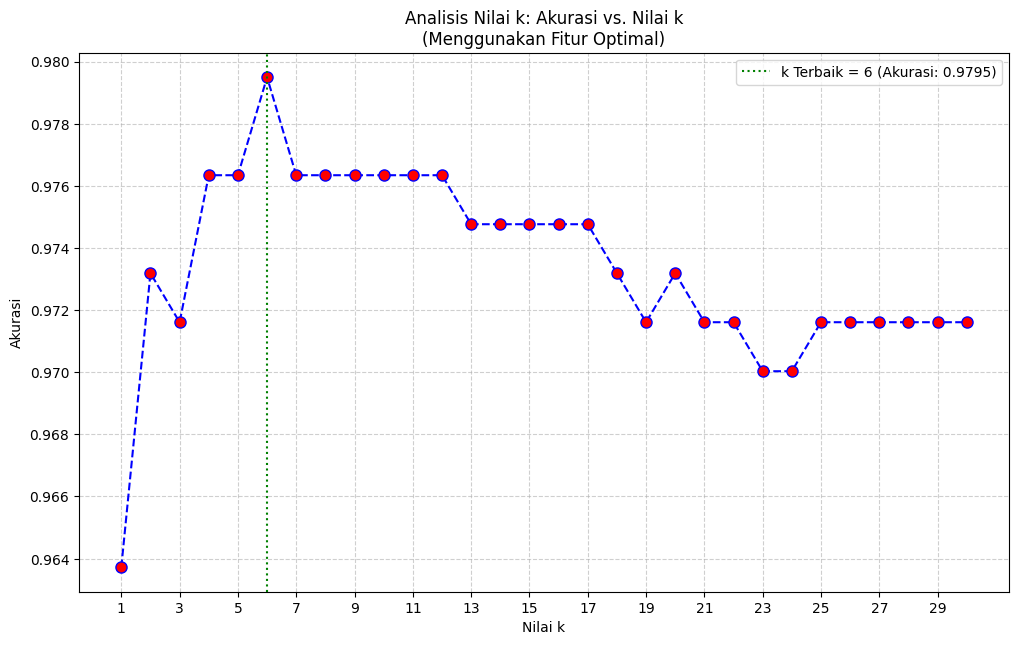

In [7]:
# --- TUGAS 3 (Lanjutan): Grafika Analisis ---
plt.figure(figsize=(12, 7))
plt.plot(k_range, accuracies, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Analisis Nilai k: Akurasi vs. Nilai k\n(Menggunakan Fitur Optimal)')
plt.xlabel('Nilai k')
plt.ylabel('Akurasi')
plt.xticks(range(1, 31, 2)) # Tampilkan label k setiap 2 angka
plt.grid(True, linestyle='--', alpha=0.6)

# Tandai nilai k terbaik
plt.axvline(x=best_k, color='green', linestyle=':', label=f'k Terbaik = {best_k} (Akurasi: {best_acc:.4f})')
plt.legend()

print("\nMenampilkan grafik analisis nilai k...")
# Simpan grafik ke file
try:
    plt.savefig('analisis_knn_k.png')
    print("Grafik juga disimpan sebagai 'analisis_knn_k.png'")
except Exception as e:
    print(f"Tidak dapat menyimpan grafik: {e}")

# Tampilkan grafik
plt.show()